In [2]:
import numpy as np
import matplotlib.pyplot as plt

array([-10.,   0.,  10., -10.,   0.,  10., -10.,   0.,  10.])

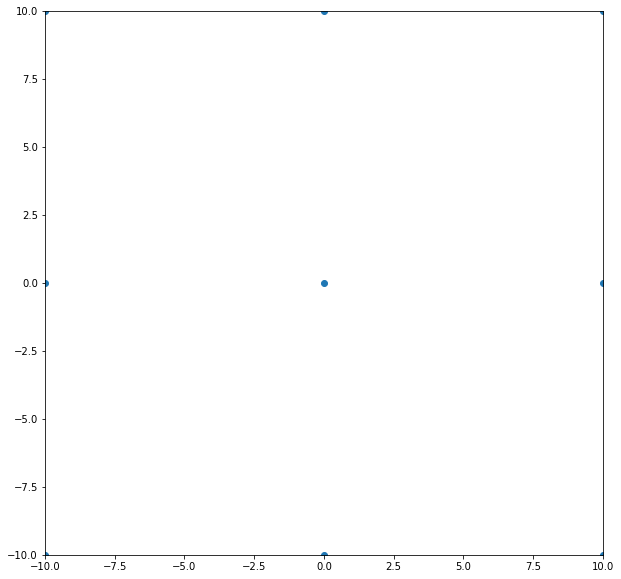

In [17]:
# Creating a mesh grid:
x_grid = np.linspace(-10,10,3)
y_grid = np.linspace(-10,10,3)
xx,yy = np.meshgrid(x_grid,y_grid)

plt.figure(figsize=(10,10))
plt.scatter(xx,yy)
plt.xlim(-10,10)
plt.ylim(-10,10)

xx.ravel()

(-10.0, 10.0)

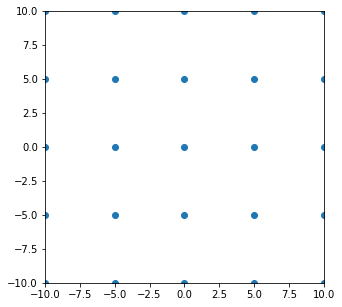

In [36]:
# Creating a mesh grid:

# boundaries of the plot
boundary = (-10,10)



x_grid = np.linspace(boundary[0],boundary[1],5)
y_grid = np.linspace(boundary[0],boundary[1],5)
xx,yy = np.meshgrid(x_grid,y_grid)

plt.figure(figsize=(5,5))
plt.scatter(xx,yy)
plt.xlim(boundary[0],boundary[1])
plt.ylim(boundary[0],boundary[1])


array([-10.        ,  -6.66666667,  -3.33333333,   0.        ,
         3.33333333,   6.66666667,  10.        , -10.        ,
        -6.66666667,  -3.33333333,   0.        ,   3.33333333,
         6.66666667,  10.        , -10.        ,  -6.66666667,
        -3.33333333,   0.        ,   3.33333333,   6.66666667,
        10.        , -10.        ,  -6.66666667,  -3.33333333,
         0.        ,   3.33333333,   6.66666667,  10.        ,
       -10.        ,  -6.66666667,  -3.33333333,   0.        ,
         3.33333333,   6.66666667,  10.        , -10.        ,
        -6.66666667,  -3.33333333,   0.        ,   3.33333333,
         6.66666667,  10.        , -10.        ,  -6.66666667,
        -3.33333333,   0.        ,   3.33333333,   6.66666667,
        10.        ])

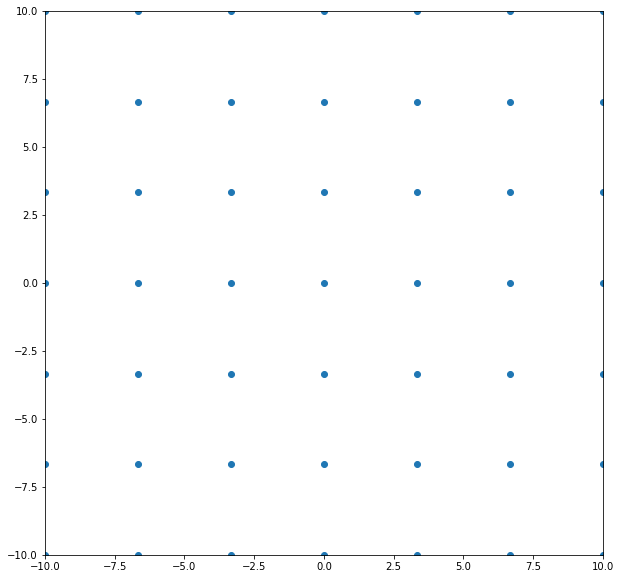

In [20]:
# Creating a mesh grid:
x_grid = np.linspace(-10,10,7)
y_grid = np.linspace(-10,10,7)
xx,yy = np.meshgrid(x_grid,y_grid)

plt.figure(figsize=(10,10))
plt.scatter(xx,yy)
plt.xlim(-10,10)
plt.ylim(-10,10)

xx.ravel()

(-10.0, 10.0)

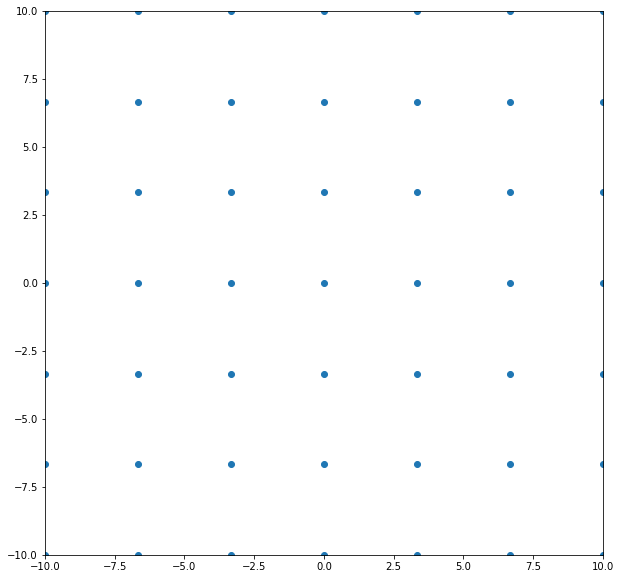

In [29]:
# Creating a mesh grid:
x_grid = np.linspace(-10,10,7)
y_grid = np.linspace(-10,10,7)
xx,yy = np.meshgrid(x_grid,y_grid)

plt.figure(figsize=(10,10))
plt.scatter(xx,yy)
plt.xlim(-10,10)
plt.ylim(-10,10)

In [ ]:
np.meshgrid(np.linspace())

In [38]:
True + True

2

In [39]:
from matplotlib.patches import Rectangle

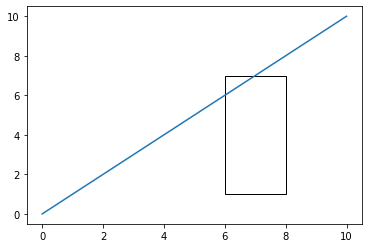

In [58]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

#define Matplotlib figure and axis
fig, ax = plt.subplots()

#create simple line plot
ax.plot([0, 10],[0, 10])

#add rectangle to plot
ax.add_patch(Rectangle((6, 1), 2, 6,fill=False,))
#display plot
plt.show()

[1000, 1000.0997999281531, 1000.1995998762785, 1000.2993998443723, 1000.3991998324303, 1000.4989998404487, 1000.5987998684235, 1000.6985999163506, 1000.7983999842262, 1000.8982000720462, 1000.9980001798067, 1001.0978003075037, 1001.1976004551332, 1001.2974006226913, 1001.3972008101739, 1001.4970010175772, 1001.596801244897, 1001.6966014921296, 1001.7964017592709, 1001.896202046317, 1001.9960023532637, 1002.0958026801073, 1002.1956030268439, 1002.2954033934693, 1002.3952037799796, 1002.4950041863709, 1002.5948046126393, 1002.6946050587808, 1002.7944055247914, 1002.8942060106672, 1002.9940065164042, 1003.0938070419984, 1003.193607587446, 1003.2934081527429, 1003.3932087378853, 1003.4930093428692, 1003.5928099676905, 1003.6926106123456, 1003.7924112768302, 1003.8922119611406, 1003.9920126652727, 1004.0918133892227, 1004.1916141329865, 1004.2914148965604, 1004.3912156799402, 1004.491016483122, 1004.5908173061022, 1004.6906181488765, 1004.7904190114411, 1004.8902198937922, 1004.990020795925

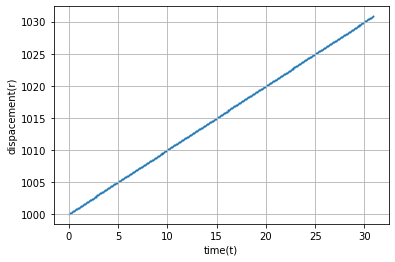

In [77]:
import numpy as np
import matplotlib.pyplot as plt

#Define constants
k = 1
a = 0.78
u = 1
#Define the differential Function
def fun(r,t):
    num = (np.sqrt((a**2)*(r**4)-(((r-u)**2)-(k**2)))*((r-u)**2-k**2))
    denom = (a*(r**4))
    return num/denom


#Define variable arrays
t_num = 310
r_num = 500
dx=0.1

r = [1000]
t = [0]

#Runge-Kutta Method
for i in range(t_num - 1):
    k1=fun(r[i],t[i])
    k2=fun(r[i]+dx/2, t[i]+dx*k1/2)
    k3=fun(r[i]+dx/2, t[i]+dx*k2/2)
    k4=fun(r[i]+dx, t[i]+dx*k3)
    
    r.append(r[i]+dx/6*(k1+2*k2+2*k3+k4))
    t.append(t[i]+dx)
    
print(r)
print(t)
plt.scatter(t,r,s=1)
plt.xlabel('time(t)')
plt.ylabel('dispacement(r)')
plt.grid()


<ipython-input-77-6ae79ed8bd41>:12: RuntimeWarning: invalid value encountered in double_scalars
  return num/denom


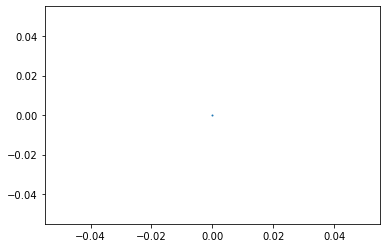

In [80]:
t = np.linspace(0,30,1000)
r = [0]
for i in range(len(t)):
    k1=fun(r[i],t[i])
    k2=fun(r[i]+dx/2, t[i]+dx*k1/2)
    k3=fun(r[i]+dx/2, t[i]+dx*k2/2)
    k4=fun(r[i]+dx, t[i]+dx*k3)
    
    r.append(r[i]+dx/6*(k1+2*k2+2*k3+k4))
    plt.scatter(t[i], r[i],s=1)
plt.show()